### Importing Libraries and Data

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

import itertools
import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

# Statistics
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE

# Machine Learning
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

print('✔️ Libraries Imported!')

✔️ Libraries Imported!


In [2]:
global df
df = pd.read_csv('Bank_Customer_Churn_dataset.csv')

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

✔️ Dataset Imported Successfully!

It contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Dropping the columns RowNumber, CustomerId and Surname as they are are specific to each customer and connt be used for prediction

In [3]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### There are no Missing Values

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


# Exploratory Data Analysis

In [6]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

In [7]:
copy_df=df.copy()

In [8]:
def plot_continuous(feature):
    df_func = copy_df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2, figsize=(9, 7), sharex=True, gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df, x=feature, bins=15, color=color, alpha=0.66, edgecolor='firebrick', label=label, kde=False, ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();

In [9]:
def plot_categorical(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature, hue='Exited', data=copy_df, palette=colors, ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature, y='Exited', data=copy_df, palette=colors_cat, ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


In [10]:
df_churned = df[df['Exited'] == 1]
df_retained = df[df['Exited'] == 0]

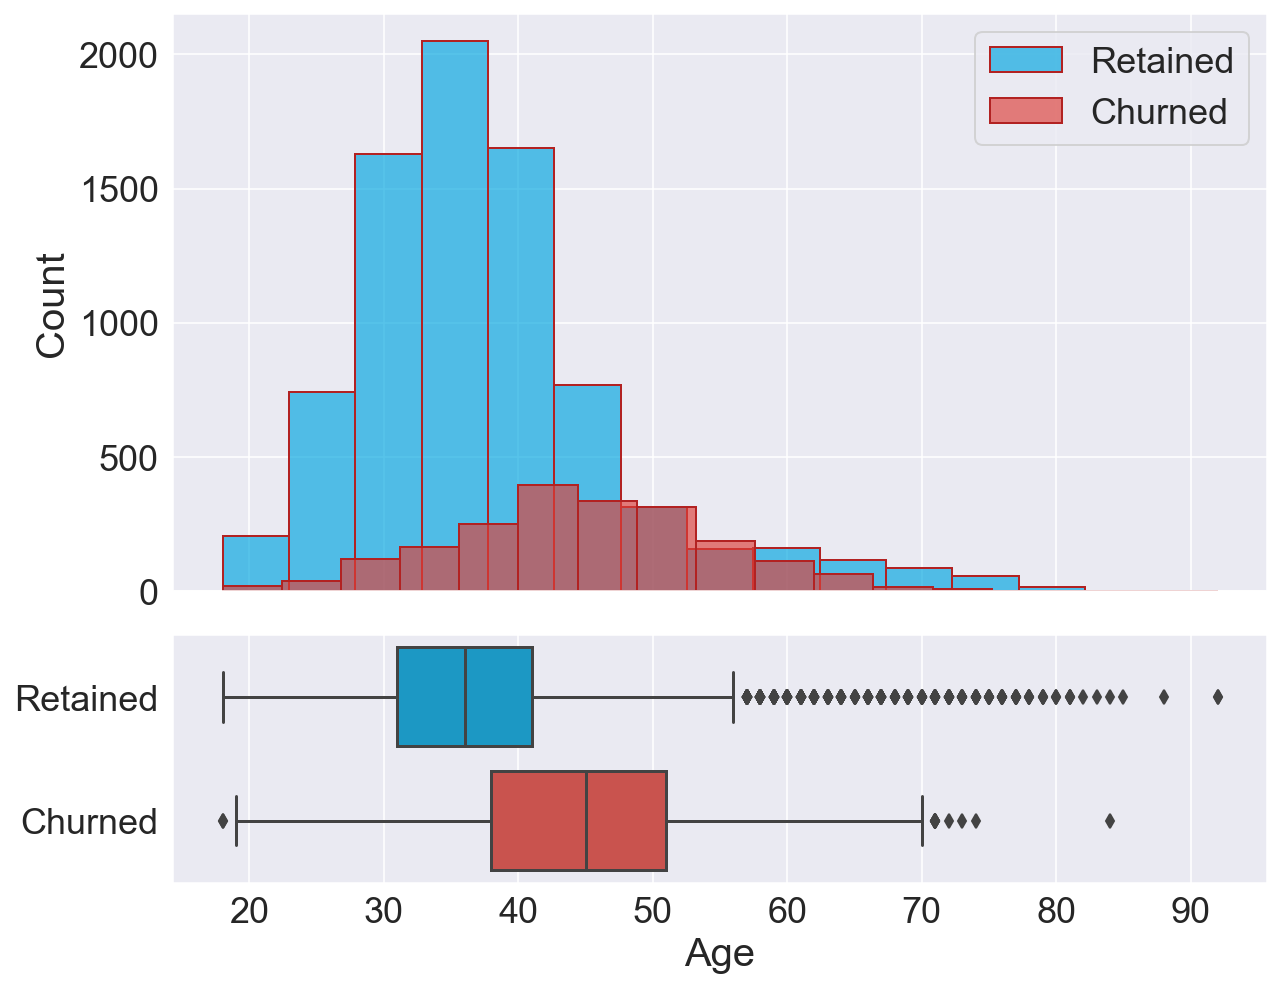

In [11]:
#Age
plot_continuous('Age')

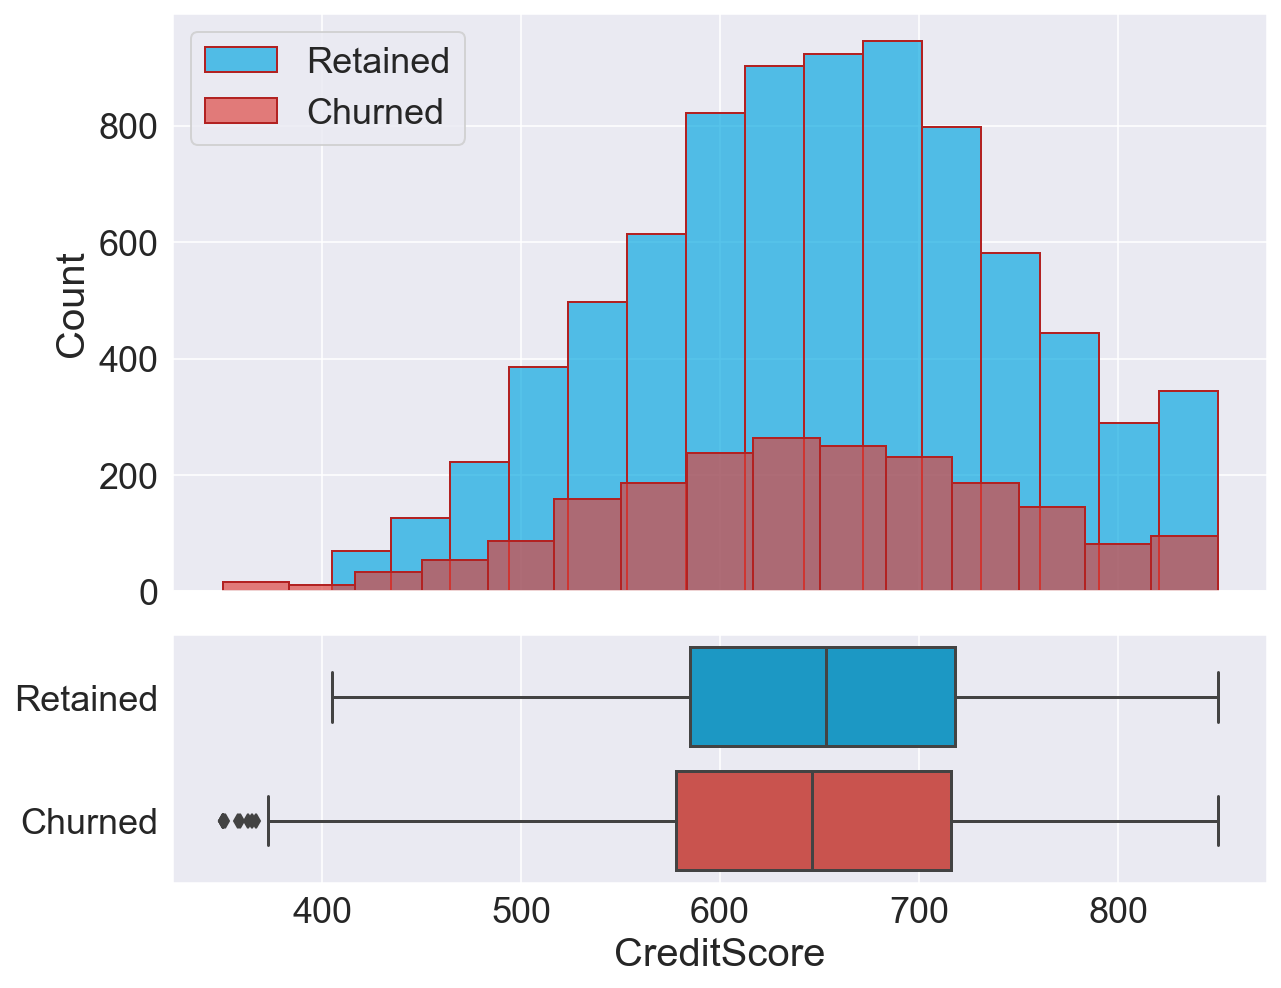

In [12]:
plot_continuous('CreditScore')

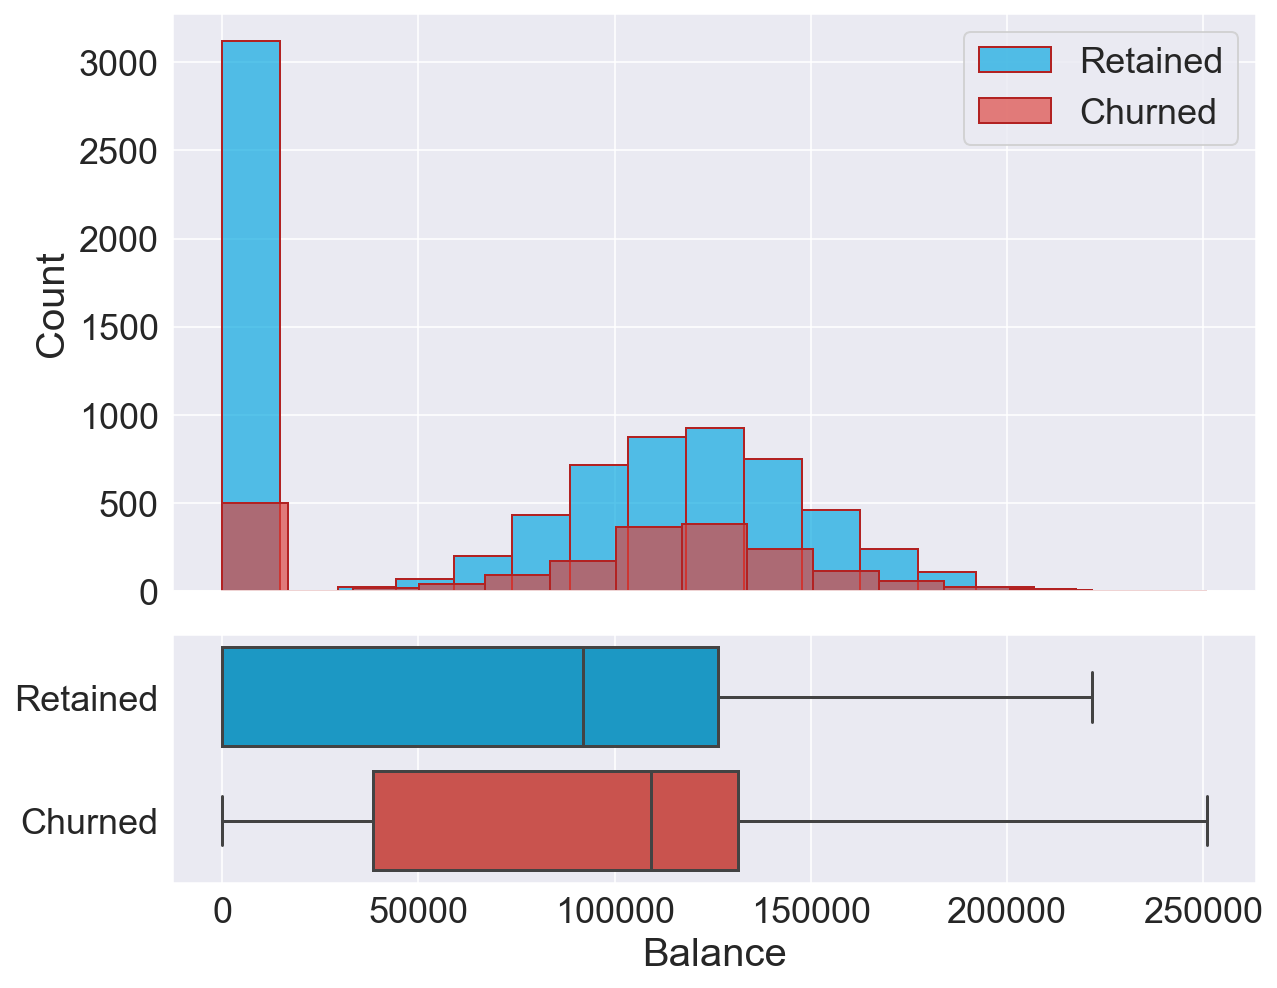

In [13]:
plot_continuous('Balance')

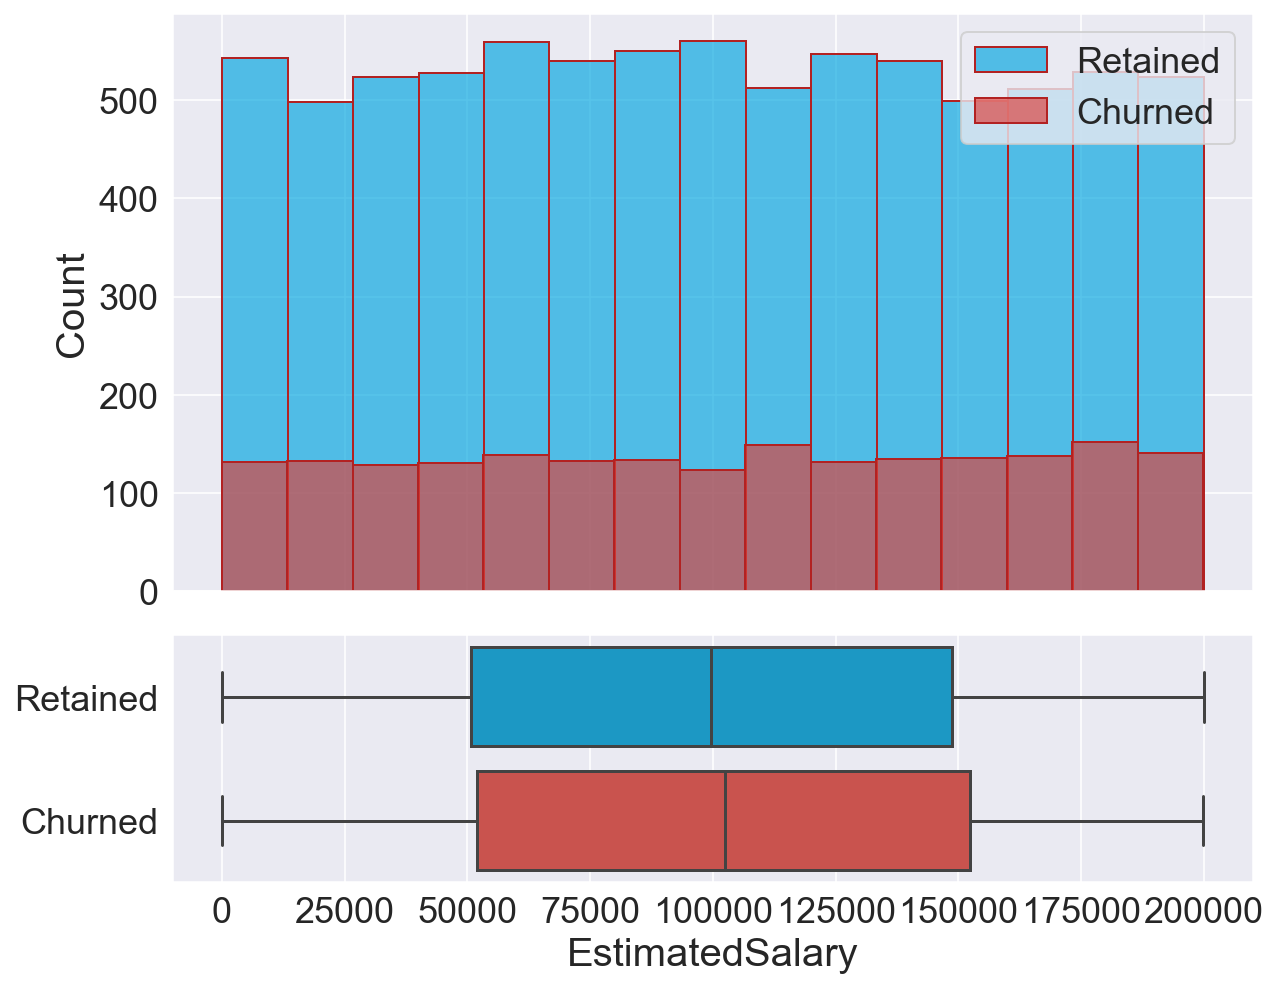

In [14]:
plot_continuous('EstimatedSalary')

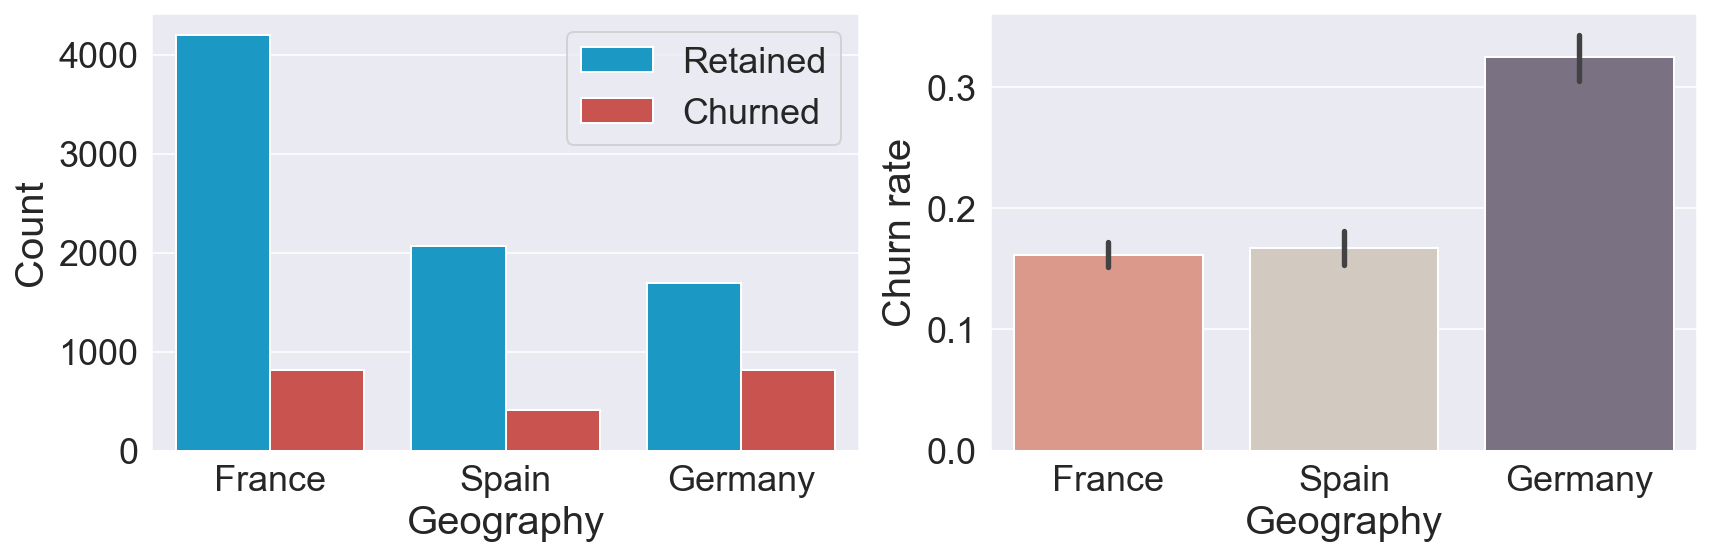

In [15]:
plot_categorical('Geography')

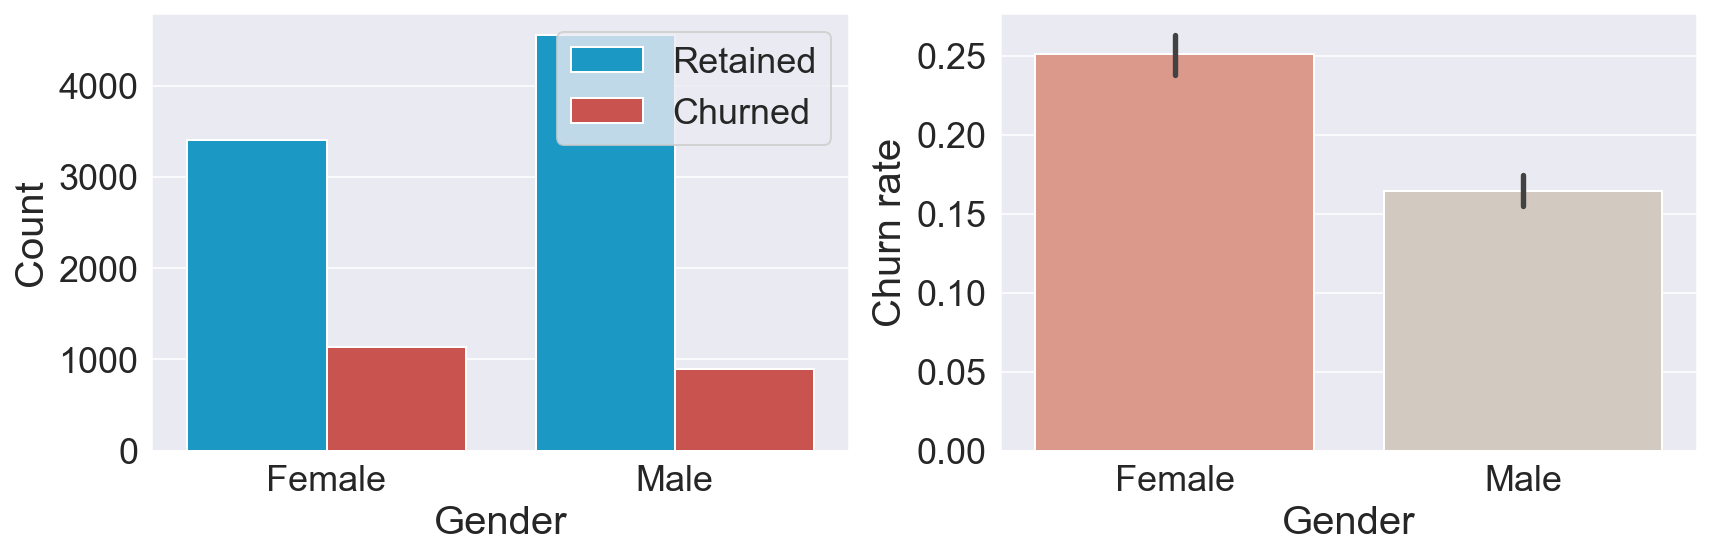

In [16]:
plot_categorical('Gender')

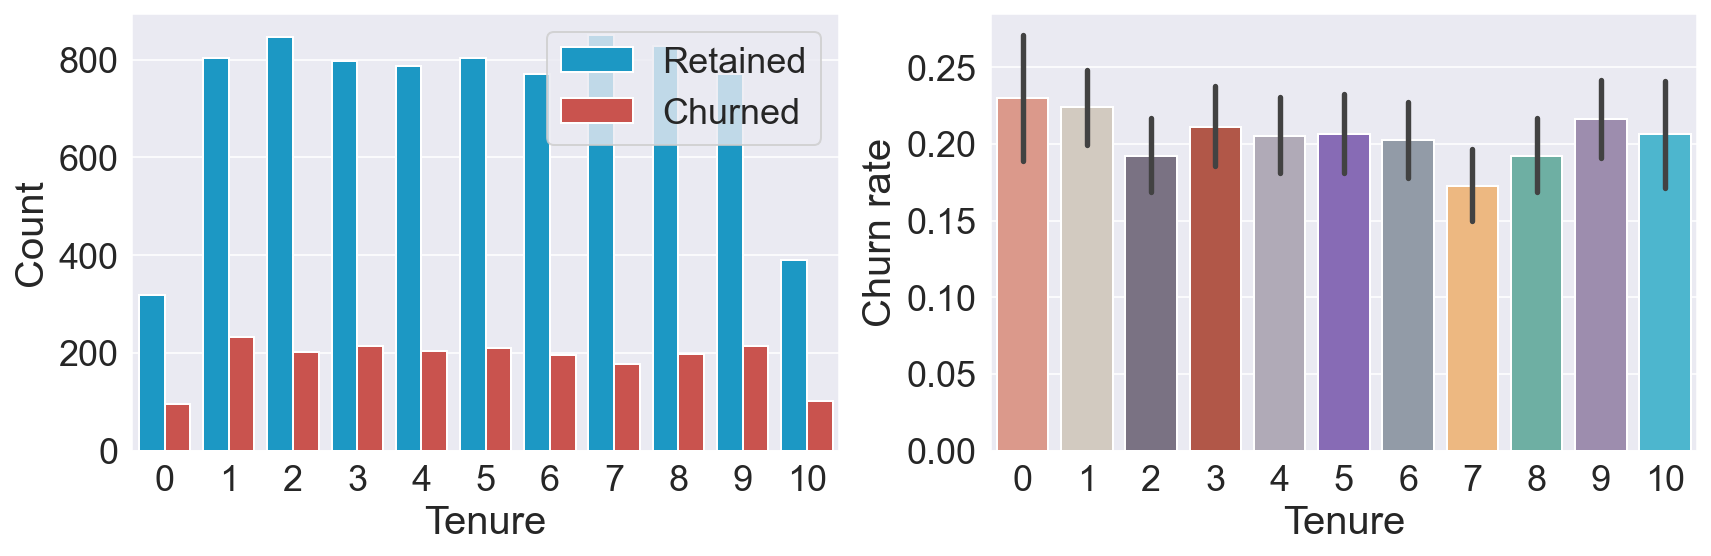

In [17]:
plot_categorical('Tenure')

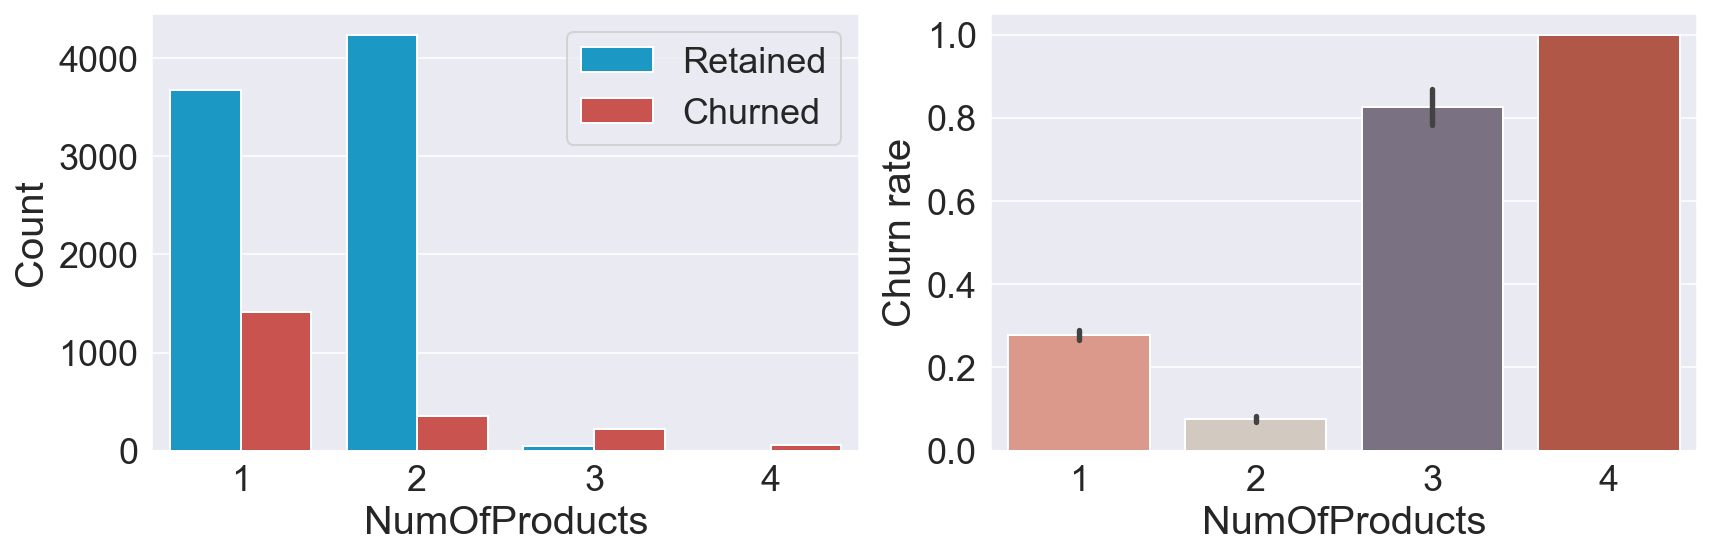

In [18]:
plot_categorical('NumOfProducts')

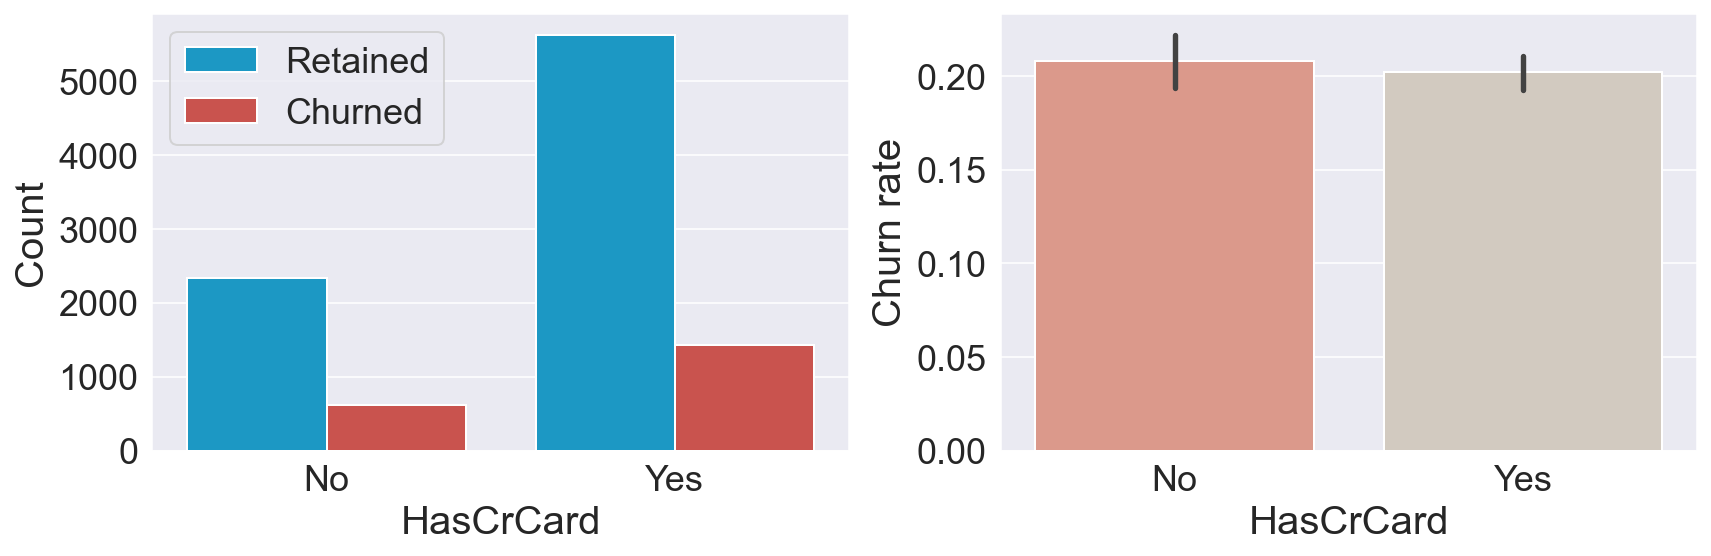

In [19]:
plot_categorical('HasCrCard')

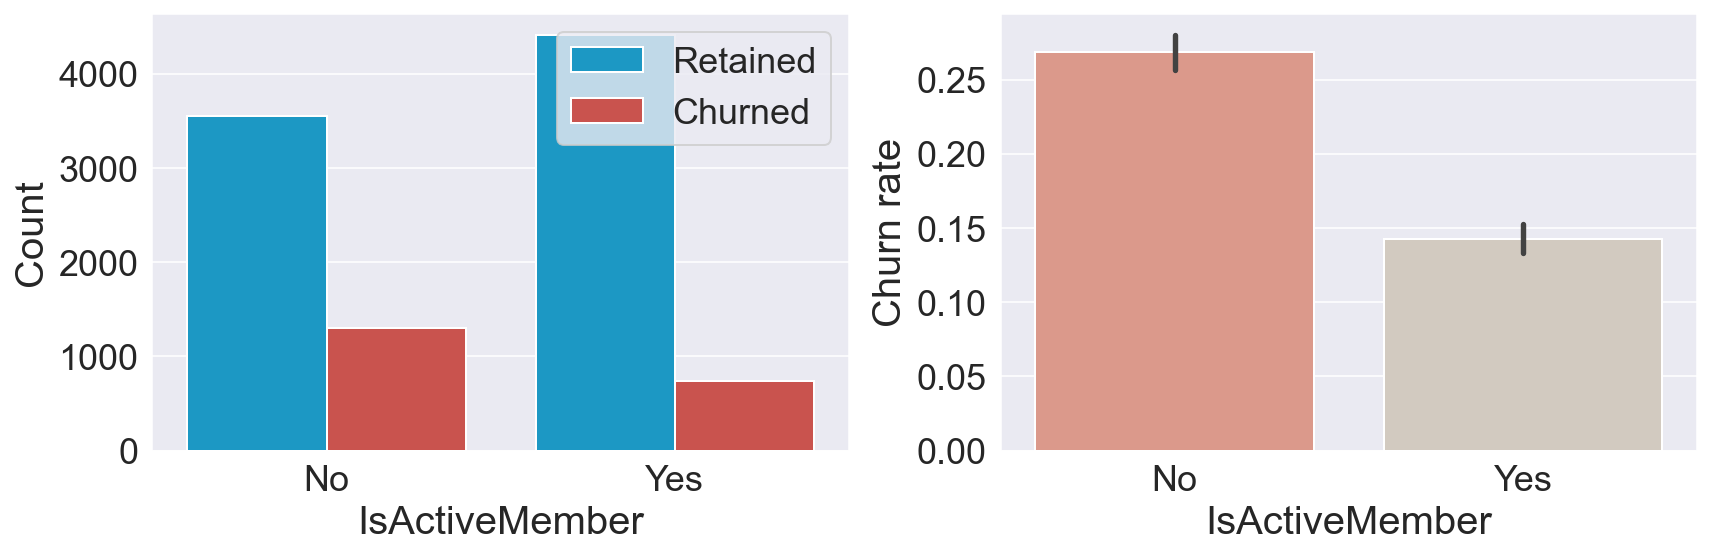

In [20]:
plot_categorical('IsActiveMember')

## Feature Engineering

In [21]:
df["NewAGT"] = df["Age"] - df["Tenure"]
df["CreditsScore"] = pd.qcut(df['CreditScore'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df["AgeScore"] = pd.qcut(df['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df["BalanceScore"] = pd.qcut(df['Balance'].rank(method="first"), 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df["EstSalaryScore"] = pd.qcut(df['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df["NewEstimatedSalary"] = df["EstimatedSalary"] / 12

In [22]:
df = pd.get_dummies(df, columns =["Geography", "Gender"], drop_first = True)

In [23]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NewAGT,CreditsScore,AgeScore,BalanceScore,EstSalaryScore,NewEstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,40,4,6,1,6,8445.740,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,40,4,6,5,6,9378.548,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,34,1,6,10,6,9494.298,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,38,7,5,1,5,7818.886,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,41,10,6,8,4,6590.342,0,1,0


### Scaling

In [24]:
copy = df[["Geography_Germany", "Geography_Spain", "Gender_Male", "HasCrCard","IsActiveMember"]]
Y=df[["Exited"]]

In [25]:
X=df.drop(["Geography_Germany", "Geography_Spain", "Gender_Male", "HasCrCard","IsActiveMember","Exited"], axis=1)

In [26]:
cols = X.columns
index = X.index

In [27]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X = transformer.transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

In [28]:
X = pd.concat([X,copy], axis = 1)

In [29]:
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,NewAGT,CreditsScore,AgeScore,BalanceScore,EstSalaryScore,NewEstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard,IsActiveMember
0,-0.246,0.417,-0.75,-0.761,0.0,0.012,0.667,-0.2,0.50,-0.9,0.1,0.012,0,0,0,1,1
1,-0.328,0.333,-1.00,-0.105,0.0,0.126,0.667,-0.2,0.50,-0.1,0.1,0.126,0,1,0,0,1
2,-1.119,0.417,0.75,0.489,2.0,0.140,0.167,-0.8,0.50,0.9,0.1,0.140,0,0,0,1,0
3,0.351,0.167,-1.00,-0.761,1.0,-0.065,0.500,0.4,0.25,-0.9,-0.1,-0.065,0,0,0,0,0
4,1.478,0.500,-0.75,0.222,0.0,-0.215,0.750,1.0,0.50,0.5,-0.3,-0.215,0,1,0,1,1


In [30]:
print(X.shape, Y.shape)

(10000, 17) (10000, 1)


### Creating a Test Set

In [31]:
# Train-Test Separation
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.20, 
                                                    random_state=12345)

In [32]:
# Oversampling the data as the data is ustable
from imblearn.combine import SMOTETomek

smk = SMOTETomek()
X_train, Y_train = smk.fit_resample(X_train, Y_train)

X_test, Y_test = smk.fit_resample(X_test, Y_test)

In [33]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(12706, 17) (12706, 1) (3132, 17) (3132, 1)


# Modelling

In [34]:
models = []
models.append(('Logistic Regression', LogisticRegression(random_state = 12345)))
models.append(('K Neighbors Classifier', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state = 12345)))
models.append(('Random Forest Classifier', RandomForestClassifier(random_state = 12345)))
models.append(('Support Vector Classifier', SVC(gamma='auto', random_state = 12345)))
models.append(('eXtreme Gradient Boost Classifier', GradientBoostingClassifier(random_state = 12345)))
models.append(("Light GBM Classifier", LGBMClassifier(random_state = 12345)))

# evaluate each model in turn
results = []
names = []

### Accuracy Score of All Models

In [35]:
for name, model in models:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

Logistic Regression: (0.738825)
K Neighbors Classifier: (0.742656)
Decision Tree Classifier: (0.790230)
Random Forest Classifier: (0.852171)
Support Vector Classifier: (0.803321)
eXtreme Gradient Boost Classifier: (0.880587)
Light GBM Classifier: (0.909323)


### We proceed with only EGB, LightGBM, CatBoost

### Importance of Variables

In [36]:
models2 = []
models2.append(('XGB', GradientBoostingClassifier( random_state = 12345)))
models2.append(("LightGBM", LGBMClassifier( random_state = 12345)))

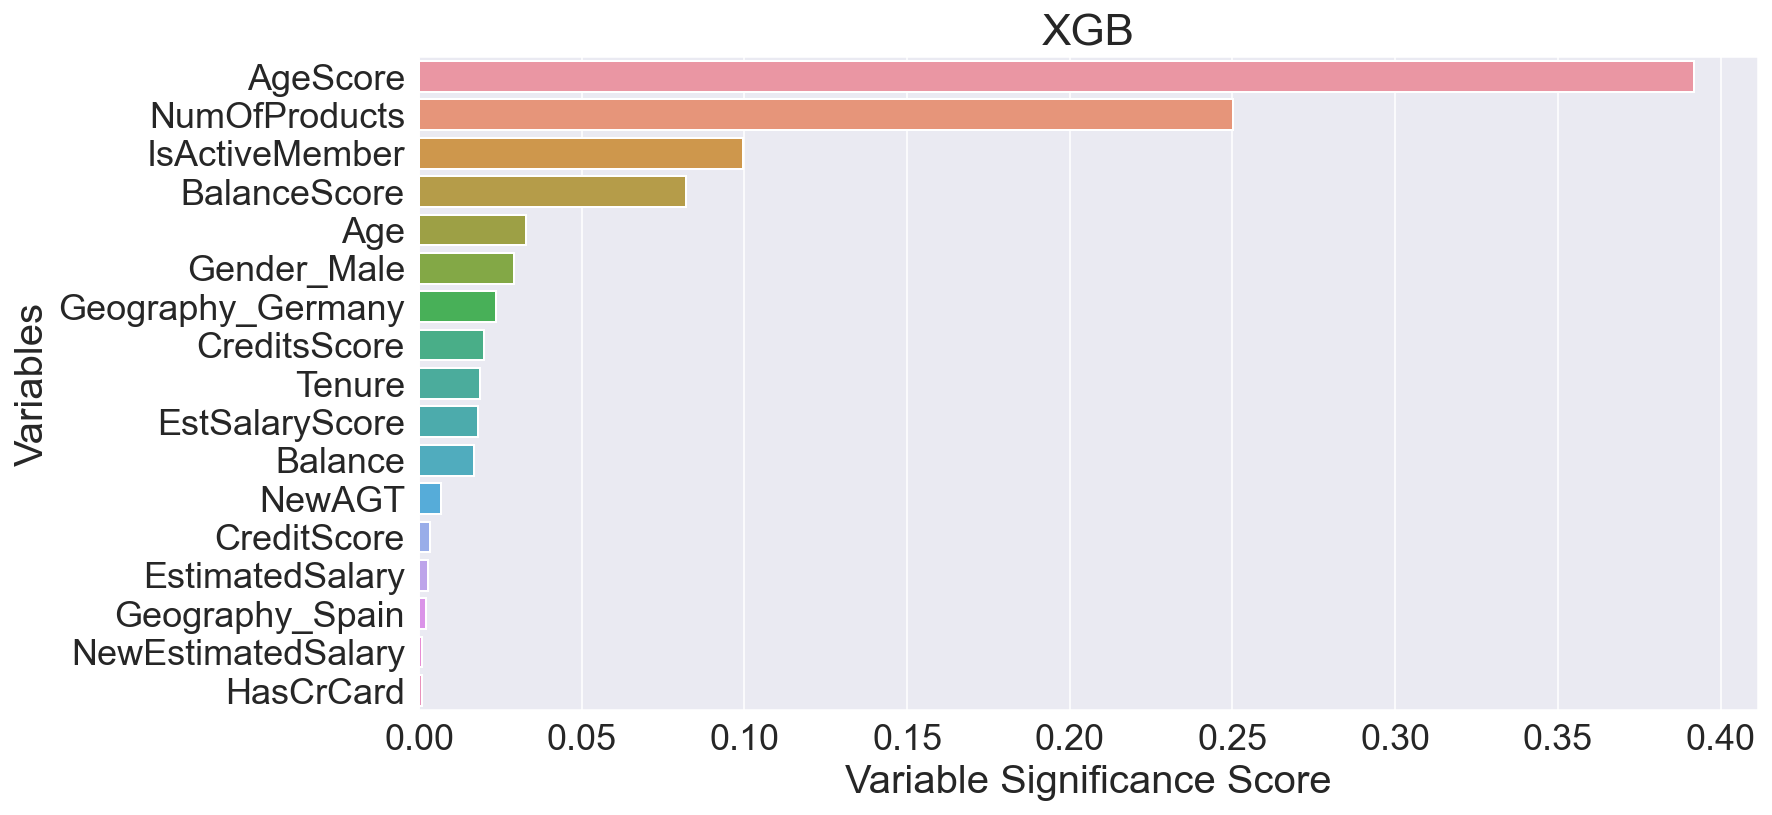

<Figure size 864x432 with 0 Axes>

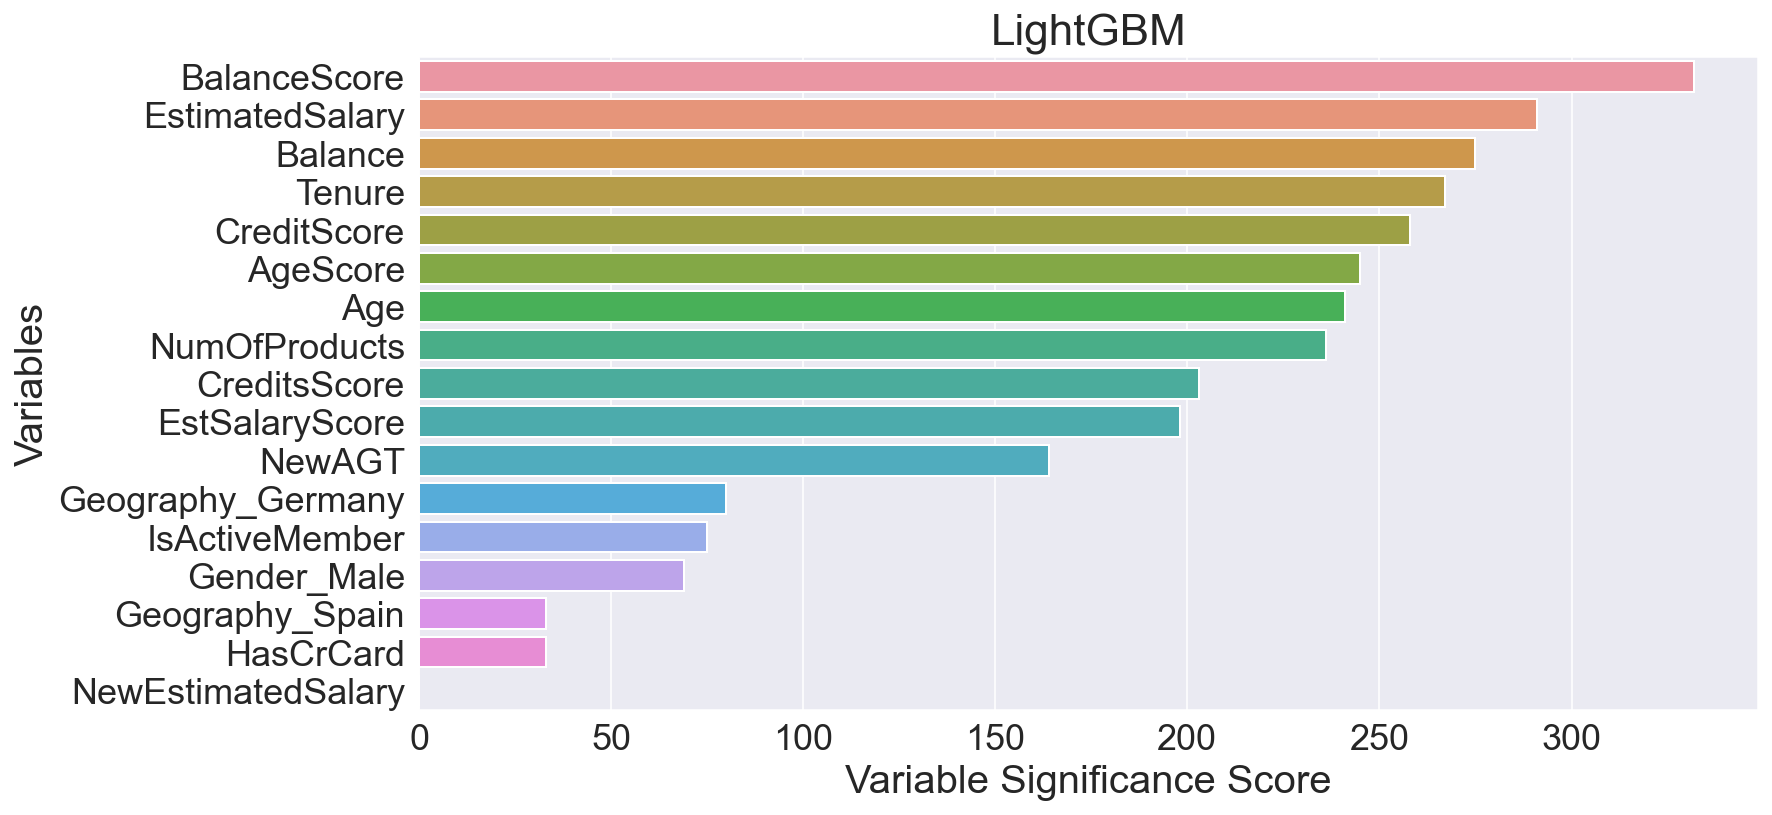

<Figure size 864x432 with 0 Axes>

In [37]:
for name, model in models2:
        base = model.fit(X_train,Y_train)
        Y_pred = base.predict(X_test)
        acc_score = accuracy_score(Y_test, Y_pred)
        feature_imp = pd.Series(base.feature_importances_, index=X.columns).sort_values(ascending=False)

        
        plt.figure(figsize=(12,6))
        sns.barplot(x=feature_imp, y=feature_imp.index)
        plt.xlabel('Variable Significance Score')
        plt.ylabel('Variables')
        plt.title(name)
        plt.figure(figsize=(12,6))

## Model Tuning

In [38]:
# Hyperparameters have previously been obtained with the help of GridSearchCV.
models = []
models.append(('XGB', GradientBoostingClassifier(random_state = 12345,learning_rate = 0.05, max_depth = 5, min_samples_split = 2, n_estimators = 500, subsample = 0.8)))
models.append(("LightGBM", LGBMClassifier(random_state = 12345,  learning_rate = 0.05, max_depth = 3, n_estimators = 1000)))

# evaluate each model in turn
results = []
names = []

for name, model in models:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        msg = "%s: (%f)" % (name, accuracy)
        print(msg)

XGB: (0.907088)
LightGBM: (0.911239)


## LightGBM is chosen for its best accuracy score

In [39]:
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
Y_pred = model.predict(X_test)
cm_xgb = confusion_matrix(Y_test, Y_pred)

TP = cm_xgb[1, 1]
TN = cm_xgb[0, 0]
FP = cm_xgb[0, 1]
FN = cm_xgb[1, 0]

In [40]:
from matplotlib import rc,rcParams
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()

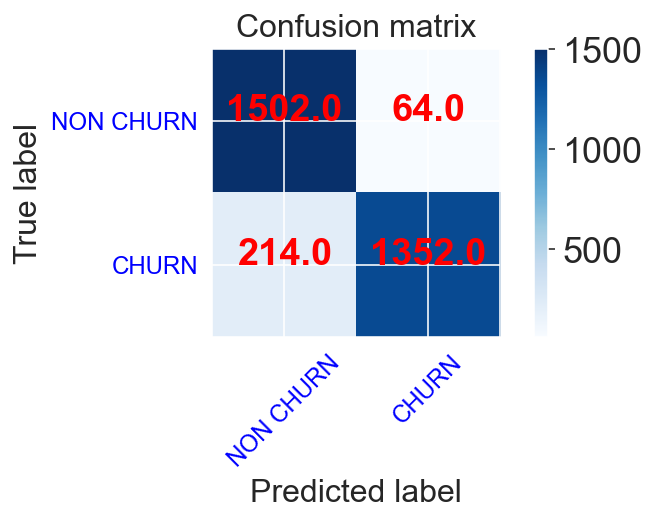

In [41]:
plot_confusion_matrix(confusion_matrix(Y_test, Y_pred), classes=['NON CHURN','CHURN'],
                      title='Confusion matrix')

In [42]:
tn, fp, fn, tp = cm_xgb.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  1502
False Positives:  64
False Negatives:  214
True Positives:  1352


In [44]:
print("The Accuracy on the above data is : ",end='')
print((tp+tn)/(fn+fp+tn+tp)*100)

The Accuracy on the above data is : 91.12388250319285
